# Logical error rate of BB code (with different cluster_node_limit for MWPF decoder)

In [1]:
# This cell is tagged `parameters` and will be override by `papermill`
json_filename: str = "bb72.json"  # where to save the result, must be provided
code: str = "bb(n=72,k=12,d=6)"
noise: str = "depolarize(p=0.01)"

slurm_maximum_jobs: int = 200
slurm_cores_per_node: int = 10  # (slurm_maximum_jobs // slurm_cores_per_node) should not exceed 200
slurm_mem_per_job: int = 4  # 4GB per job
slurm_walltime: str = "11:00:00"  # 11 hours (adaptively shutdown if no more jobs)
slurm_partition: str = "scavenge"

local_maximum_jobs: int = 10

min_shots: int = 10_000_000  # p_L between 6.7e-5 ~ 3.9e-5

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from qec_lego_bench.hpc.monte_carlo import MonteCarloJob, LogicalErrorResult, MonteCarloJobExecutor
from qec_lego_bench.hpc.submitter.min_shots_submitter import MinShotsSubmitter
from qec_lego_bench.hpc.submitter.precision_submitter import PrecisionSubmitter
from qec_lego_bench.hpc.plotter.job_progress_plotter import JobProgressPlotter
from qec_lego_bench.hpc.plotter.logical_error_rate_plotter import LogicalErrorRatePlotter
from typing import Iterable
from qec_lego_bench.cli.logical_error_rate import logical_error_rate

### Define the job list

In [4]:
# cluster_node_limit
c_vec = list(range(201)) + [1000 * (10 ** i) for i in range(4)]

jobs = [MonteCarloJob(c=c) for c in c_vec]


def monte_carlo_function(shots: int, c: int) -> tuple[int, LogicalErrorResult]:
    stats = logical_error_rate(decoder=f"mwpf(c={c})", code=code, noise=noise, max_shots=shots, max_errors=shots, no_progress=True, no_print=True)
    return stats.shots, LogicalErrorResult(errors=stats.errors, discards=stats.discards)

monte_carlo_function(1000, min(c_vec))

(1000, LogicalErrorResult(errors=0, discards=0))

### Define the strategy to submit jobs

In [5]:
min_shots_submitter = MinShotsSubmitter(shots=min_shots)
precision_submitter = PrecisionSubmitter(time_limit=10*3600, min_precision=0.3)
more_precision_submitter = PrecisionSubmitter(time_limit=50*3600, min_precision=0.1, target_precision=0.01)
def submitter(jobs: Iterable[MonteCarloJob]) -> list[tuple[MonteCarloJob, int]]:
    submit = min_shots_submitter(jobs)
    submit += precision_submitter(jobs)
    if len(submit) == 0 and all([job.pending_shots == 0 for job in jobs]):  # previous submitter all finished
        submit += more_precision_submitter(jobs)
    return submit

### Define the callback, e.g. plotting the intermediate result and the list of remaining tasks

In [6]:
from qec_lego_bench.hpc.monte_carlo import *
import matplotlib.pyplot as plt
from IPython import display
from dataclasses import field
from typing import Optional

@dataclass
class ClusterNodeLimitPlotter:
    c_vec: list[int]

    hdisplay: display.DisplayHandle = field(
        default_factory=lambda: display.display("", display_id=True)
    )

    def __call__(self, executor: MonteCarloJobExecutor):
        x_vec = []
        y_vec = []
        err_vec = []
        display_c_of = lambda c: c if c != 0 else 0.5
        for c in self.c_vec:
            job = executor.get_job(c=c)
            if job is None or job.result is None:
                continue
            x_vec.append(display_c_of(c))
            stats = job.result.stats_of(job)  # type: ignore
            y_vec.append(stats.failure_rate_value)
            err_vec.append(stats.failure_rate_uncertainty)
        if len(x_vec) == 0:
            return
        fig, ax = plt.subplots(1, 1)
        ax.clear()
        ax.errorbar(x_vec, y_vec, err_vec, label=f"noise={noise}")
        ax.set_xlabel("cluster node limit")
        ax.set_ylabel("logical error rate $p_L$")
        ax.set_xlim(display_c_of(min(self.c_vec)) / 2, max(self.c_vec) * 2)
        ax.set_xscale("log")
        ax.set_ylim(1e-5, 1e-4)
        ax.set_yscale("log")
        fig.legend()
        self.hdisplay.update(fig)
        plt.close(fig)

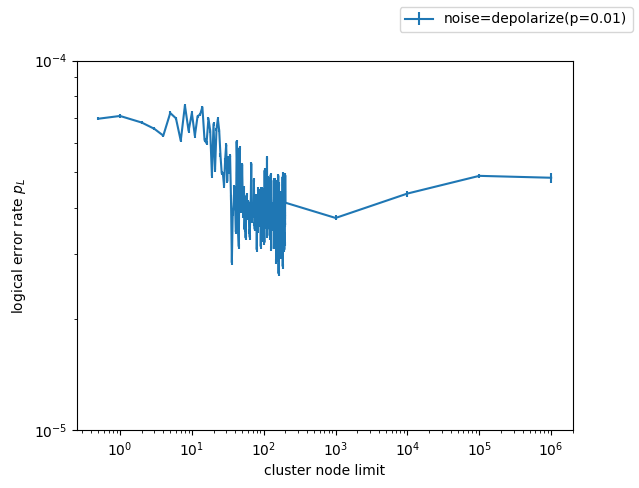

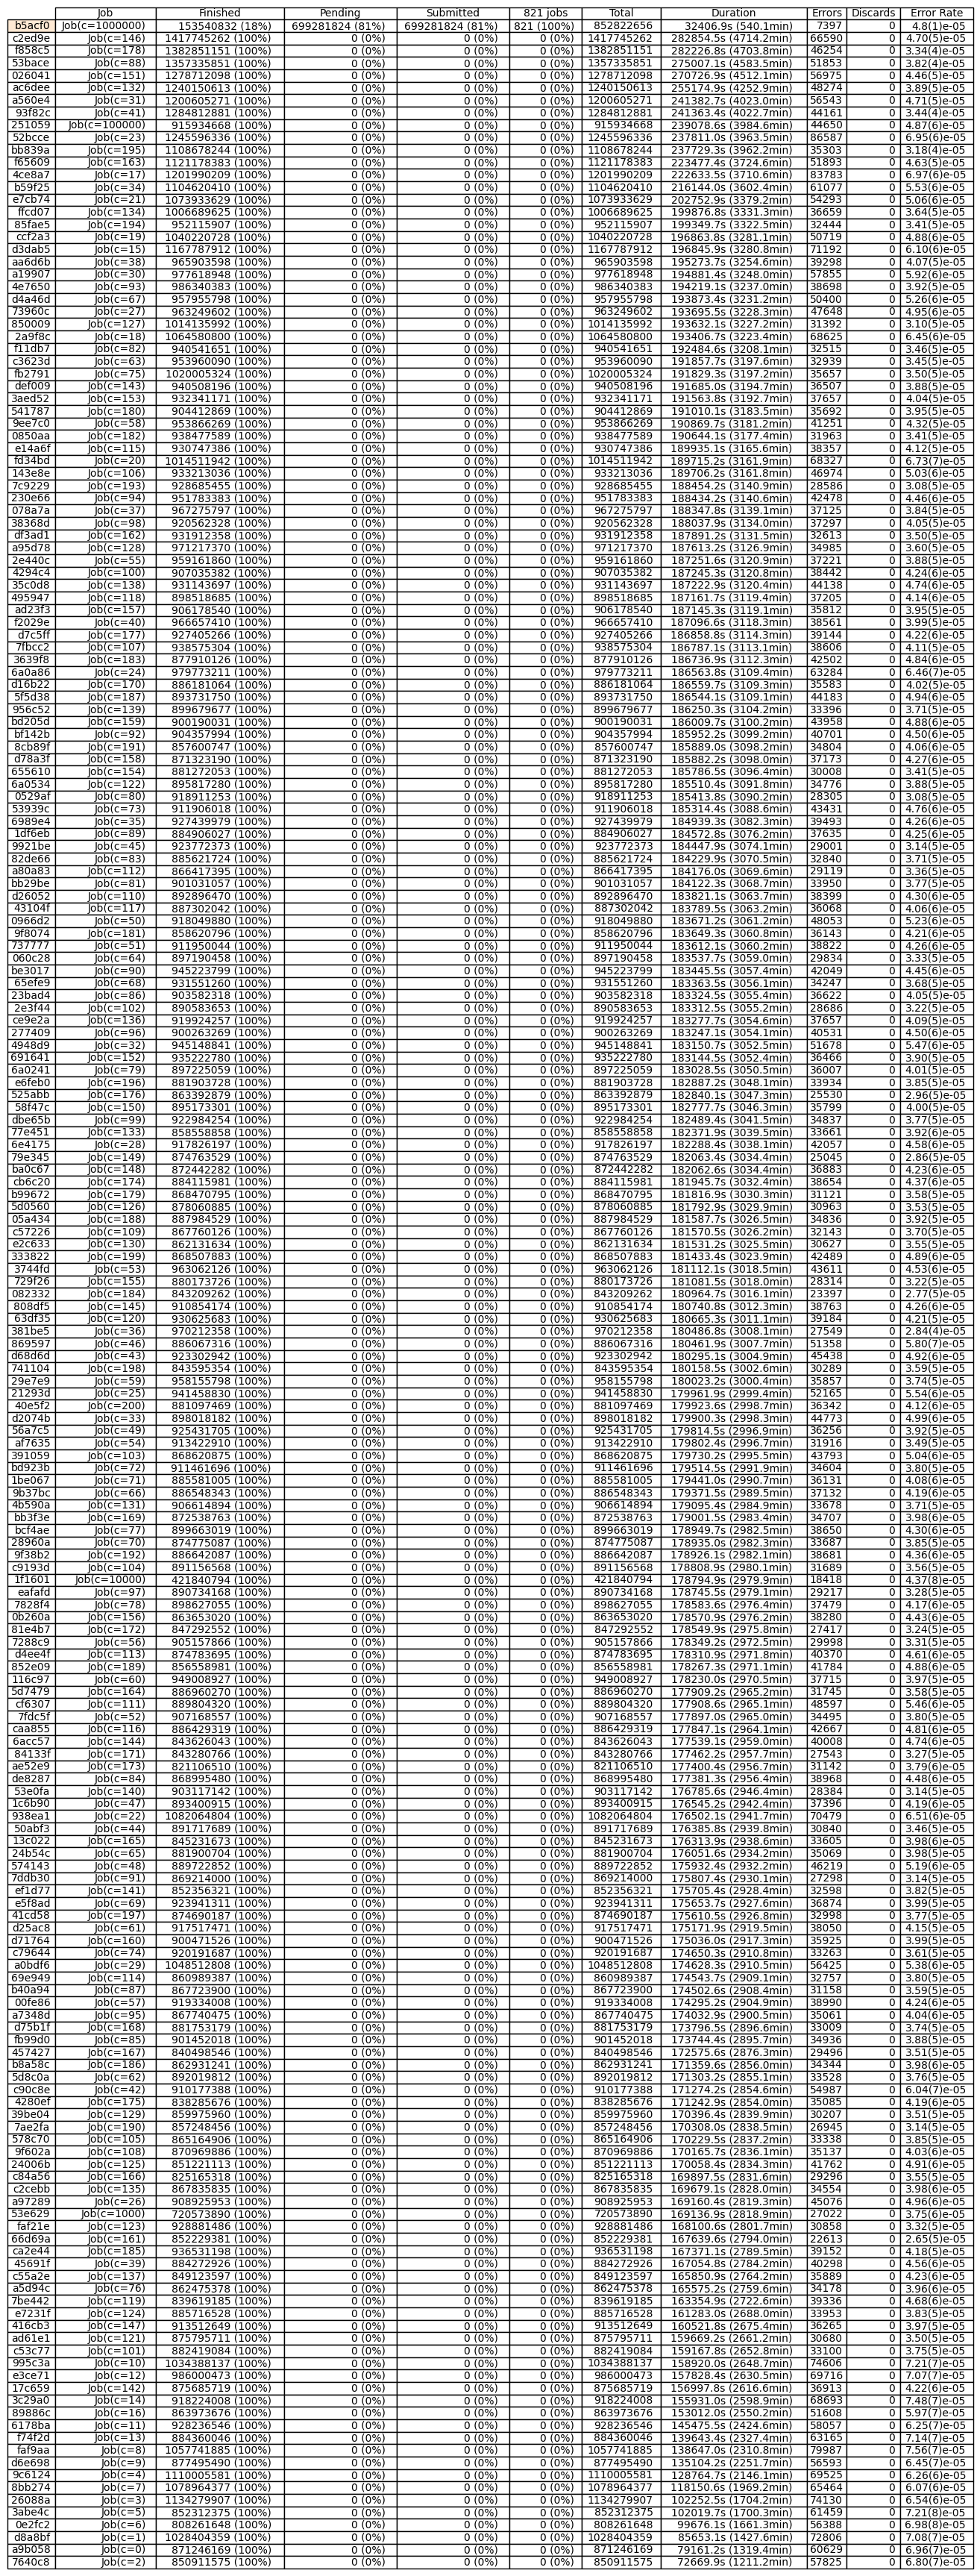

In [7]:
plotter = ClusterNodeLimitPlotter(c_vec)
progress_plotter = JobProgressPlotter()
def callback(executor: MonteCarloJobExecutor):
    plotter(executor)
    progress_plotter(executor)

## The rest of the notebook runs the evaluation

In [8]:
try:
    from dask_jobqueue import SLURMCluster
    from dask.distributed import Client
    n_workers = slurm_maximum_jobs // slurm_cores_per_node
    assert n_workers <= 200, "Yale HPC forbids submitting more than 200 jobs per hour"
    slurm_job_folder = os.path.join(os.path.abspath(os.getcwd()), "slurm_job")
    cluster = SLURMCluster(
        queue=slurm_partition,
        cores=slurm_cores_per_node,
        processes=slurm_cores_per_node,
        memory=f"{slurm_mem_per_job * slurm_cores_per_node} GB",
        walltime=slurm_walltime,
        job_extra_directives=[f'--out="{slurm_job_folder}/%j.out"', f'--error="{slurm_job_folder}/%j.err"'],
    )
    print(cluster.job_script())
    # cluster.scale(slurm_maximum_jobs)
    cluster.adapt(minimum=slurm_maximum_jobs, maximum=slurm_maximum_jobs)  # allow respawn
    shudown_cluster = True
except Exception as e:
    print(e)
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster(n_workers=local_maximum_jobs)
    shudown_cluster = False

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p scavenge
#SBATCH -n 1
#SBATCH --cpus-per-task=10
#SBATCH --mem=38G
#SBATCH -t 11:00:00
#SBATCH --out="/gpfs/gibbs/project/lin_zhong/yw729/qec-lego-bench/docs/notebooks/evaluation/logical-error-rate/different-cluster-node-limit-/slurm_job/%j.out"
#SBATCH --error="/gpfs/gibbs/project/lin_zhong/yw729/qec-lego-bench/docs/notebooks/evaluation/logical-error-rate/different-cluster-node-limit-/slurm_job/%j.err"

/home/yw729/.conda/envs/qec/bin/python -m distributed.cli.dask_worker tcp://10.181.184.83:37513 --name dummy-name --nthreads 1 --memory-limit 3.73GiB --nworkers 10 --nanny --death-timeout 60



In [9]:
print(cluster.dashboard_link)
cluster

http://10.181.184.83:8787/status


Dashboard: http://10.181.184.83:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.181.184.83:37513,Workers: 0
Dashboard: http://10.181.184.83:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [10]:
if shudown_cluster:
    print("will shut down the cluster after job finishes; if this is not desired, set `shudown_cluster` to False")
with Client(cluster) as client:
    try:
        executor = MonteCarloJobExecutor(
            client,
            monte_carlo_function,
            jobs,
            filename=json_filename,
        )
        executor.execute(submitter, loop_callback=callback)
    finally:
        if shudown_cluster:
            print("shutting down the whole cluster; if this is not desired, set `shudown_cluster` to False")
            client.shutdown()

will shut down the cluster after job finishes; if this is not desired, set `shudown_cluster` to False


2025-01-31 13:42:22,217 - bokeh.server.protocol_handler - ERROR - error handling message
 message: Message 'PATCH-DOC' content: {'events': [{'kind': 'ModelChanged', 'model': {'id': 'p65959'}, 'attr': 'inner_width', 'new': 835}, {'kind': 'ModelChanged', 'model': {'id': 'p65959'}, 'attr': 'inner_height', 'new': 20}, {'kind': 'ModelChanged', 'model': {'id': 'p65959'}, 'attr': 'outer_width', 'new': 855}, {'kind': 'ModelChanged', 'model': {'id': 'p65959'}, 'attr': 'outer_height', 'new': 100}]} 
 error: AssertionError()
Traceback (most recent call last):
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/protocol_handler.py", line 94, in handle
    work = await handler(message, connection)
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/session.py", line 295, in patch
    return connection.session._handle_patch(message, connection)
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/connection.py", line 65, in

2025-01-31 13:42:22,308 - bokeh.server.protocol_handler - ERROR - error handling message
 message: Message 'PATCH-DOC' content: {'events': [{'kind': 'ModelChanged', 'model': {'id': 'p66000'}, 'attr': 'start', 'new': 306862694.4}, {'kind': 'ModelChanged', 'model': {'id': 'p66000'}, 'attr': 'end', 'new': 364295577.6}]} 
 error: AssertionError()
Traceback (most recent call last):
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/protocol_handler.py", line 94, in handle
    work = await handler(message, connection)
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/session.py", line 295, in patch
    return connection.session._handle_patch(message, connection)
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/connection.py", line 65, in session
    assert self._session is not None
AssertionError


2025-01-31 13:42:22,335 - bokeh.server.protocol_handler - ERROR - error handling message
 message: Message 'PATCH-DOC' content: {'events': [{'kind': 'ModelChanged', 'model': {'id': 'p66001'}, 'attr': 'start', 'new': -1.7000000000000028}, {'kind': 'ModelChanged', 'model': {'id': 'p66001'}, 'attr': 'end', 'new': 35.7}]} 
 error: AssertionError()
Traceback (most recent call last):
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/protocol_handler.py", line 94, in handle
    work = await handler(message, connection)
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/session.py", line 295, in patch
    return connection.session._handle_patch(message, connection)
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/connection.py", line 65, in session
    assert self._session is not None
AssertionError


2025-01-31 13:42:22,353 - bokeh.server.protocol_handler - ERROR - error handling message
 message: Message 'PATCH-DOC' content: {'events': [{'kind': 'ModelChanged', 'model': {'id': 'p65999'}, 'attr': 'inner_width', 'new': 796}, {'kind': 'ModelChanged', 'model': {'id': 'p65999'}, 'attr': 'inner_height', 'new': 464}, {'kind': 'ModelChanged', 'model': {'id': 'p65999'}, 'attr': 'outer_width', 'new': 855}, {'kind': 'ModelChanged', 'model': {'id': 'p65999'}, 'attr': 'outer_height', 'new': 534}]} 
 error: AssertionError()
Traceback (most recent call last):
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/protocol_handler.py", line 94, in handle
    work = await handler(message, connection)
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/session.py", line 295, in patch
    return connection.session._handle_patch(message, connection)
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/connection.py", line 65, i

2025-01-31 13:42:22,375 - bokeh.server.protocol_handler - ERROR - error handling message
 message: Message 'PATCH-DOC' content: {'events': [{'kind': 'ModelChanged', 'model': {'id': 'p66036'}, 'attr': 'start', 'new': -0.10000000000000009}, {'kind': 'ModelChanged', 'model': {'id': 'p66036'}, 'attr': 'end', 'new': 2.1}]} 
 error: AssertionError()
Traceback (most recent call last):
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/protocol_handler.py", line 94, in handle
    work = await handler(message, connection)
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/session.py", line 295, in patch
    return connection.session._handle_patch(message, connection)
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/connection.py", line 65, in session
    assert self._session is not None
AssertionError


2025-01-31 13:42:22,383 - bokeh.server.protocol_handler - ERROR - error handling message
 message: Message 'PATCH-DOC' content: {'events': [{'kind': 'ModelChanged', 'model': {'id': 'p66037'}, 'attr': 'start', 'new': -7.75}, {'kind': 'ModelChanged', 'model': {'id': 'p66037'}, 'attr': 'end', 'new': 162.75}]} 
 error: AssertionError()
Traceback (most recent call last):
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/protocol_handler.py", line 94, in handle
    work = await handler(message, connection)
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/session.py", line 295, in patch
    return connection.session._handle_patch(message, connection)
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/connection.py", line 65, in session
    assert self._session is not None
AssertionError


2025-01-31 13:42:22,420 - bokeh.server.protocol_handler - ERROR - error handling message
 message: Message 'PATCH-DOC' content: {'events': [{'kind': 'ModelChanged', 'model': {'id': 'p66102'}, 'attr': 'start', 'new': -10.444999999999993}, {'kind': 'ModelChanged', 'model': {'id': 'p66102'}, 'attr': 'end', 'new': 209.445}]} 
 error: AssertionError()
Traceback (most recent call last):
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/protocol_handler.py", line 94, in handle
    work = await handler(message, connection)
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/session.py", line 295, in patch
    return connection.session._handle_patch(message, connection)
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/connection.py", line 65, in session
    assert self._session is not None
AssertionError


2025-01-31 13:42:22,429 - bokeh.server.protocol_handler - ERROR - error handling message
 message: Message 'PATCH-DOC' content: {'events': [{'kind': 'ModelChanged', 'model': {'id': 'p66142'}, 'attr': 'end', 'new': 219726.4178756083}]} 
 error: AssertionError()
Traceback (most recent call last):
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/protocol_handler.py", line 94, in handle
    work = await handler(message, connection)
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/session.py", line 295, in patch
    return connection.session._handle_patch(message, connection)
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/connection.py", line 65, in session
    assert self._session is not None
AssertionError


2025-01-31 13:42:22,445 - bokeh.server.protocol_handler - ERROR - error handling message
 message: Message 'PATCH-DOC' content: {'events': [{'kind': 'ModelChanged', 'model': {'id': 'p66143'}, 'attr': 'start', 'new': -10.444999999999993}, {'kind': 'ModelChanged', 'model': {'id': 'p66143'}, 'attr': 'end', 'new': 209.445}]} 
 error: AssertionError()
Traceback (most recent call last):
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/protocol_handler.py", line 94, in handle
    work = await handler(message, connection)
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/session.py", line 295, in patch
    return connection.session._handle_patch(message, connection)
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/connection.py", line 65, in session
    assert self._session is not None
AssertionError


2025-01-31 13:42:22,448 - bokeh.server.protocol_handler - ERROR - error handling message
 message: Message 'PATCH-DOC' content: {'events': [{'kind': 'ModelChanged', 'model': {'id': 'p66192'}, 'attr': 'start', 'new': -10.995000000000005}, {'kind': 'ModelChanged', 'model': {'id': 'p66192'}, 'attr': 'end', 'new': 230.895}]} 
 error: AssertionError()
Traceback (most recent call last):
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/protocol_handler.py", line 94, in handle
    work = await handler(message, connection)
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/session.py", line 295, in patch
    return connection.session._handle_patch(message, connection)
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/connection.py", line 65, in session
    assert self._session is not None
AssertionError


2025-01-31 13:42:22,454 - bokeh.server.protocol_handler - ERROR - error handling message
 message: Message 'PATCH-DOC' content: {'events': [{'kind': 'ModelChanged', 'model': {'id': 'p66035'}, 'attr': 'inner_width', 'new': 790}, {'kind': 'ModelChanged', 'model': {'id': 'p66035'}, 'attr': 'inner_height', 'new': 425}, {'kind': 'ModelChanged', 'model': {'id': 'p66035'}, 'attr': 'outer_width', 'new': 855}, {'kind': 'ModelChanged', 'model': {'id': 'p66035'}, 'attr': 'outer_height', 'new': 505}]} 
 error: AssertionError()
Traceback (most recent call last):
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/protocol_handler.py", line 94, in handle
    work = await handler(message, connection)
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/session.py", line 295, in patch
    return connection.session._handle_patch(message, connection)
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/connection.py", line 65, i

2025-01-31 13:42:22,469 - bokeh.server.protocol_handler - ERROR - error handling message
 message: Message 'PATCH-DOC' content: {'events': [{'kind': 'ModelChanged', 'model': {'id': 'p66100'}, 'attr': 'inner_width', 'new': 790}, {'kind': 'ModelChanged', 'model': {'id': 'p66100'}, 'attr': 'inner_height', 'new': 425}, {'kind': 'ModelChanged', 'model': {'id': 'p66100'}, 'attr': 'outer_width', 'new': 855}, {'kind': 'ModelChanged', 'model': {'id': 'p66100'}, 'attr': 'outer_height', 'new': 505}]} 
 error: AssertionError()
Traceback (most recent call last):
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/protocol_handler.py", line 94, in handle
    work = await handler(message, connection)
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/session.py", line 295, in patch
    return connection.session._handle_patch(message, connection)
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/connection.py", line 65, i

2025-01-31 13:42:22,470 - bokeh.server.protocol_handler - ERROR - error handling message
 message: Message 'PATCH-DOC' content: {'events': [{'kind': 'ModelChanged', 'model': {'id': 'p66141'}, 'attr': 'inner_width', 'new': 790}, {'kind': 'ModelChanged', 'model': {'id': 'p66141'}, 'attr': 'inner_height', 'new': 425}, {'kind': 'ModelChanged', 'model': {'id': 'p66141'}, 'attr': 'outer_width', 'new': 855}, {'kind': 'ModelChanged', 'model': {'id': 'p66141'}, 'attr': 'outer_height', 'new': 505}]} 
 error: AssertionError()
Traceback (most recent call last):
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/protocol_handler.py", line 94, in handle
    work = await handler(message, connection)
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/session.py", line 295, in patch
    return connection.session._handle_patch(message, connection)
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/connection.py", line 65, i

2025-01-31 13:42:22,474 - bokeh.server.protocol_handler - ERROR - error handling message
 message: Message 'PATCH-DOC' content: {'events': [{'kind': 'ModelChanged', 'model': {'id': 'p66190'}, 'attr': 'inner_width', 'new': 790}, {'kind': 'ModelChanged', 'model': {'id': 'p66190'}, 'attr': 'inner_height', 'new': 425}, {'kind': 'ModelChanged', 'model': {'id': 'p66190'}, 'attr': 'outer_width', 'new': 855}, {'kind': 'ModelChanged', 'model': {'id': 'p66190'}, 'attr': 'outer_height', 'new': 505}]} 
 error: AssertionError()
Traceback (most recent call last):
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/protocol_handler.py", line 94, in handle
    work = await handler(message, connection)
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/session.py", line 295, in patch
    return connection.session._handle_patch(message, connection)
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/connection.py", line 65, i

2025-01-31 13:42:22,480 - bokeh.server.protocol_handler - ERROR - error handling message
 message: Message 'PATCH-DOC' content: {'events': [{'kind': 'ModelChanged', 'model': {'id': 'p66250'}, 'attr': 'start', 'new': -125680.50909042358}, {'kind': 'ModelChanged', 'model': {'id': 'p66250'}, 'attr': 'end', 'new': 354085.00591659546}]} 
 error: AssertionError()
Traceback (most recent call last):
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/protocol_handler.py", line 94, in handle
    work = await handler(message, connection)
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/session.py", line 295, in patch
    return connection.session._handle_patch(message, connection)
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/connection.py", line 65, in session
    assert self._session is not None
AssertionError


2025-01-31 13:42:22,485 - bokeh.server.protocol_handler - ERROR - error handling message
 message: Message 'PATCH-DOC' content: {'events': [{'kind': 'ModelChanged', 'model': {'id': 'p66251'}, 'attr': 'start', 'new': -0.20000000000000284}, {'kind': 'ModelChanged', 'model': {'id': 'p66251'}, 'attr': 'end', 'new': 99.7}]} 
 error: AssertionError()
Traceback (most recent call last):
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/protocol_handler.py", line 94, in handle
    work = await handler(message, connection)
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/session.py", line 295, in patch
    return connection.session._handle_patch(message, connection)
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/connection.py", line 65, in session
    assert self._session is not None
AssertionError


2025-01-31 13:42:22,499 - bokeh.server.protocol_handler - ERROR - error handling message
 message: Message 'PATCH-DOC' content: {'events': [{'kind': 'ModelChanged', 'model': {'id': 'p66252'}, 'attr': 'inner_width', 'new': 2545}, {'kind': 'ModelChanged', 'model': {'id': 'p66252'}, 'attr': 'inner_height', 'new': 661}, {'kind': 'ModelChanged', 'model': {'id': 'p66252'}, 'attr': 'outer_width', 'new': 2565}, {'kind': 'ModelChanged', 'model': {'id': 'p66252'}, 'attr': 'outer_height', 'new': 741}]} 
 error: AssertionError()
Traceback (most recent call last):
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/protocol_handler.py", line 94, in handle
    work = await handler(message, connection)
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/session.py", line 295, in patch
    return connection.session._handle_patch(message, connection)
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/connection.py", line 65,

2025-01-31 13:42:22,529 - bokeh.server.protocol_handler - ERROR - error handling message
 message: Message 'PATCH-DOC' content: {'events': [{'kind': 'ModelChanged', 'model': {'id': 'p66314'}, 'attr': 'start', 'new': 0}, {'kind': 'ModelChanged', 'model': {'id': 'p66314'}, 'attr': 'end', 'new': 0.9}]} 
 error: AssertionError()
Traceback (most recent call last):
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/protocol_handler.py", line 94, in handle
    work = await handler(message, connection)
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/session.py", line 295, in patch
    return connection.session._handle_patch(message, connection)
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/connection.py", line 65, in session
    assert self._session is not None
AssertionError


2025-01-31 13:42:22,532 - bokeh.server.protocol_handler - ERROR - error handling message
 message: Message 'PATCH-DOC' content: {'events': [{'kind': 'ModelChanged', 'model': {'id': 'p66316'}, 'attr': 'inner_width', 'new': 2545}, {'kind': 'ModelChanged', 'model': {'id': 'p66316'}, 'attr': 'inner_height', 'new': 347}, {'kind': 'ModelChanged', 'model': {'id': 'p66316'}, 'attr': 'outer_width', 'new': 2565}, {'kind': 'ModelChanged', 'model': {'id': 'p66316'}, 'attr': 'outer_height', 'new': 427}]} 
 error: AssertionError()
Traceback (most recent call last):
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/protocol_handler.py", line 94, in handle
    work = await handler(message, connection)
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/session.py", line 295, in patch
    return connection.session._handle_patch(message, connection)
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/bokeh/server/connection.py", line 65,

2025-01-31 13:42:22,533 - tornado.application - ERROR - Uncaught exception GET /status/ws (10.181.0.11)
HTTPServerRequest(protocol='http', host='localhost:8989', method='GET', uri='/status/ws', version='HTTP/1.1', remote_ip='10.181.0.11')
Traceback (most recent call last):
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/tornado/web.py", line 1790, in _execute
    result = await result
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/tornado/websocket.py", line 273, in get
    await self.ws_connection.accept_connection(self)
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/tornado/websocket.py", line 863, in accept_connection
    await self._accept_connection(handler)
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/tornado/websocket.py", line 946, in _accept_connection
    await self._receive_frame_loop()
  File "/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/tornado/websocket.py", line 1105, in _receive_frame_l